In [1]:
from orbitflows.flow import normFlow as nf
from orbitflows import generate_sho_orbits, H_sho, H, scaled_H_std
from orbitflows.integrate import eulerstep, rungekutta4
import torch
from functools import partial
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

In [80]:
generate_sho_orbits(10, 1, 10, 100)[0].shape

torch.Size([10, 100, 2])

In [130]:
model = nf.GsympNetFlow(2, 10, 32)

In [ ]:
ps0 = 0.1*torch.randn((50, 2), requires_grad=True) + torch.tensor([0.5, 0])

(-1.0, 1.0)

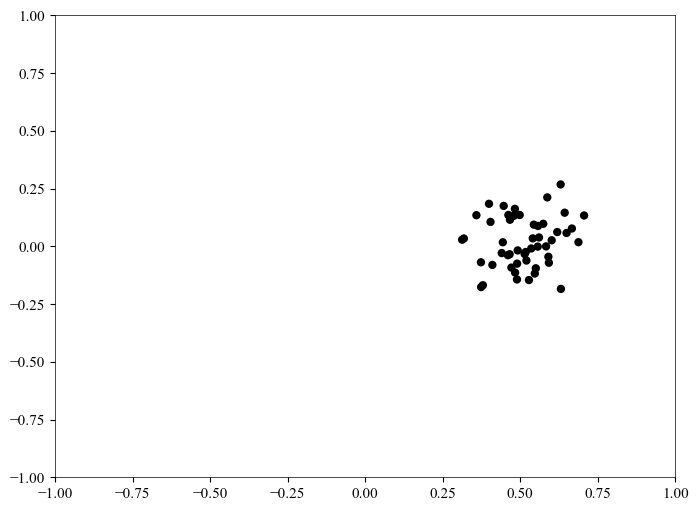

In [56]:
plt.scatter(*ps0.T.detach())
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [107]:
def integrate(ps, steps, dt, stepfunc, potential=isoDiskPotential):
    """
    Integrate the system of particles using the Euler method.
    
    Parameters:
    ps (list): List of Particle objects.
    steps (int): Number of integration steps.
    dt (float): Time step for integration.
    
    Returns:
    None
    """
    ps_list = torch.zeros((steps + 1, len(ps), len(ps[0])))#, len(ps), 2))
    ps_list[0] = ps
    for j, ps_ in enumerate(ps):
        for i in range(steps):
            ps_ = stepfunc(ps_, dt, partial(H, potential_for_H = potential))
            ps_list[i+1, j] = ps_
    return ps_list.movedim(0, 1)

In [108]:
old_potential = partial(isoDiskPotential, amp=1, sigma=0.1)
ps_og = integrate(ps0, 100, 0.1, rungekutta4, old_potential)

In [112]:
ps0.detach().shape

torch.Size([50, 2])

In [116]:
ps_og[-1].detach().shape

torch.Size([101, 2])

AttributeError: 'Tensor' object has no attribute 'Tdetach'

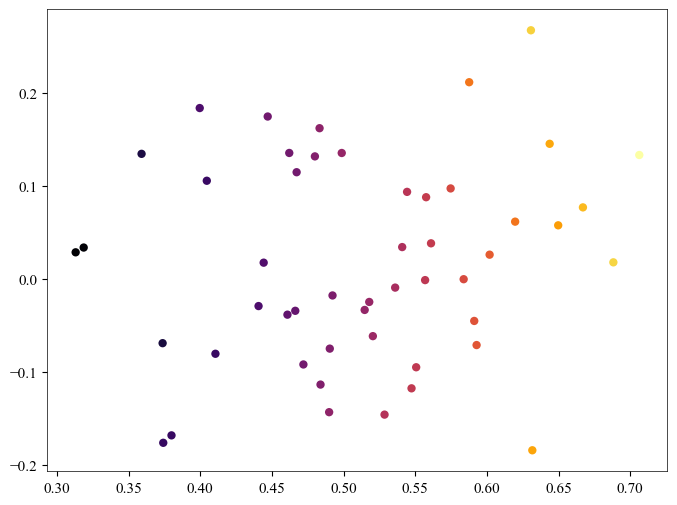

In [117]:
plt.scatter(*ps0.T.detach(), c=H_sho(ps0).detach())
plt.scatter(*ps_og[:,-1].Tdetach(),c=H_sho(ps_og)[:, -1].detach(), cmap='viridis')
#plt.scatter(*ps_og[5].T.detach(),c=H_sho(ps_og)[5].T.detach(), cmap='viridis')
plt.xlabel('q')
plt.ylabel('p')

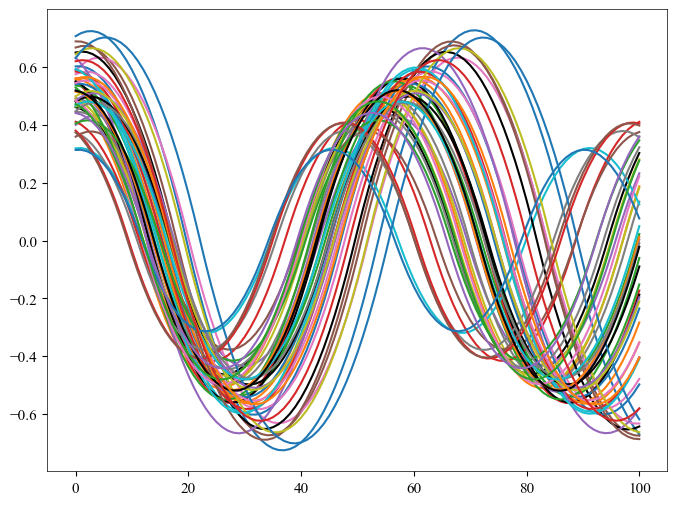

In [60]:
plt.plot(ps_og[...,0].detach())

In [118]:
def train(model, targetPotential, training_data, steps, lr=1e-4, loss_function=scaled_H_std, lf_args=None):
    '''
    Train the model.
    
    Parameters
    ----------

    training_data : torch.Tensor
        Training data to use for the model. Should be of shape (n_orbits, n_steps, 2).

    steps : int
        Number of steps to train the model.

    lr : float
        Learning rate for the training.

    loss_function : callable
        Loss function to use for the training.
    
    lf_args : dict
        Arguments to pass to the loss function.
        If the loss function is scaled_H_std, then lf_args should contain
        the target potential to use for the training.
    '''
    if loss_function == scaled_H_std and lf_args is None:
        lf_args={'targetPotential' : targetPotential}
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(steps)):
        nf_output = model(training_data)
        loss = loss_function(nf_output, **lf_args)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    return loss.item()

Text(0, 0.5, 'potential')

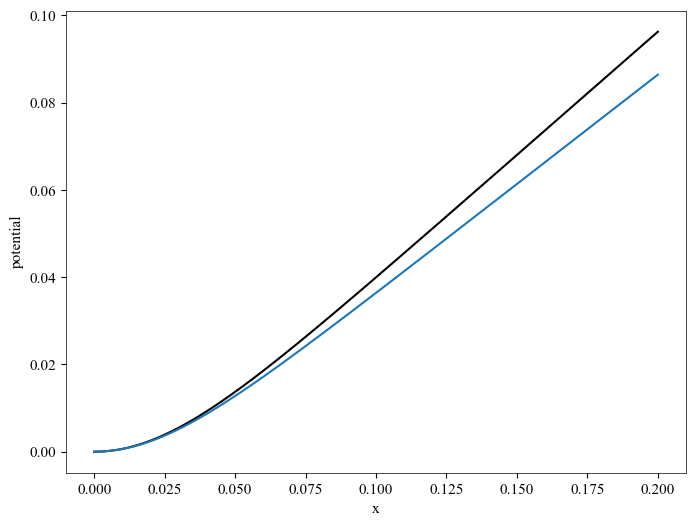

In [119]:
x_list = torch.linspace(0, 0.2, 1000)
new_pot = partial(isoDiskPotential, amp=1.05, sigma=0.11)
plt.plot(x_list, new_pot(x_list))
plt.plot(x_list, isoDiskPotential(x_list, amp=1, sigma=0.1))
plt.xlabel('x')
plt.ylabel('potential')

In [166]:
loss_ls = train(model, new_pot, ps_og[::5].clone().detach().requires_grad_(), 1000)

100%|██████████| 1000/1000 [00:10<00:00, 98.89it/s]


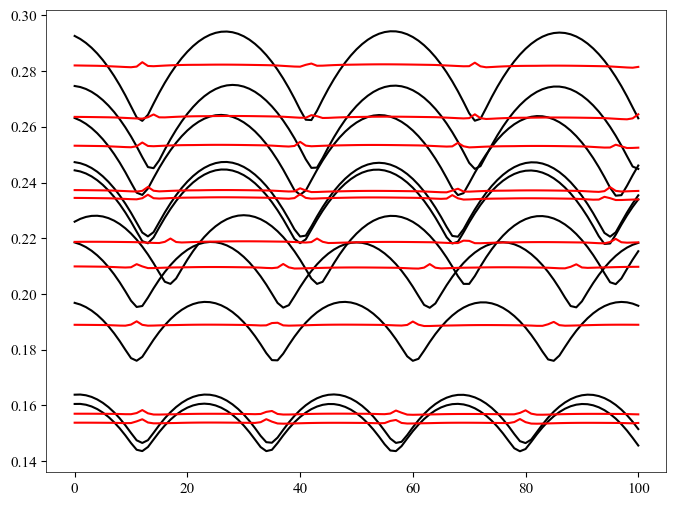

In [167]:
plt.plot(H(ps_og[::5], potential_for_H = new_pot).detach().T, c='k')
plt.plot(H(model(ps_og[::5]), potential_for_H = new_pot).detach().T, c='r')

In [168]:
ps_og.shape

torch.Size([50, 101, 2])

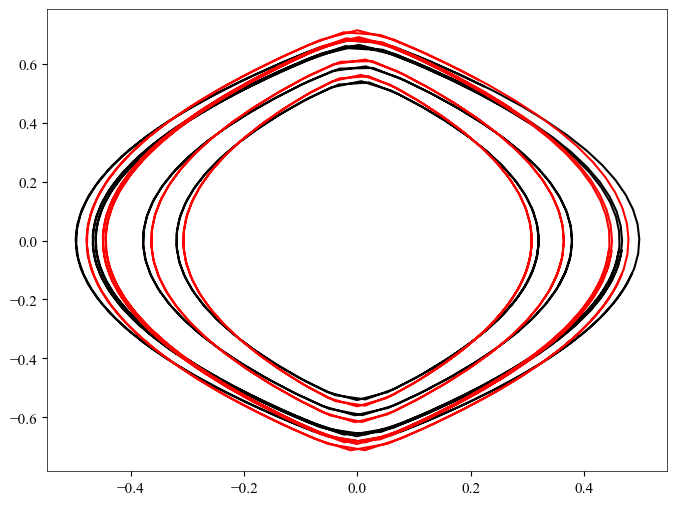

In [175]:
plt.plot(ps_og.detach()[::10,:,0].T, ps_og.detach()[::10,:,1].T, c='k')
plt.plot(model(ps_og).detach()[::10,:,0].T, model(ps_og).detach()[::10,:,1].T, c='r')

In [176]:
# Use example : only have to integrate steam backwards in one potential and can use those results along with this model to assess how things vary for it in different potentials == would need to add another paramter that tracks how the potential changes too though.

In [177]:
from time import time

In [178]:
time()

1748646591.370173

In [181]:
ps_new_numerical

tensor([[[ 0.4608, -0.0386],
         [ 0.4542, -0.0951],
         [ 0.4418, -0.1516],
         ...,
         [ 0.4231,  0.2095],
         [ 0.4412,  0.1529],
         [ 0.4536,  0.0964]],

        [[ 0.7064,  0.1333],
         [ 0.7169,  0.0768],
         [ 0.7217,  0.0203],
         ...,
         [-0.7172, -0.0090],
         [-0.7152,  0.0475],
         [-0.7077,  0.1040]],

        [[ 0.4899, -0.1436],
         [ 0.4728, -0.2001],
         [ 0.4499, -0.2566],
         ...,
         [ 0.3739,  0.3912],
         [ 0.4102,  0.3347],
         [ 0.4409,  0.2782]],

        ...,

        [[ 0.4720, -0.0922],
         [ 0.4599, -0.1487],
         [ 0.4422, -0.2052],
         ...,
         [ 0.4184,  0.2622],
         [ 0.4418,  0.2057],
         [ 0.4596,  0.1492]],

        [[ 0.6197,  0.0616],
         [ 0.6231,  0.0050],
         [ 0.6207, -0.0515],
         ...,
         [-0.4553,  0.4361],
         [-0.4088,  0.4927],
         [-0.3568,  0.5492]],

        [[ 0.4407, -0.0293],
       

In [ ]:
st = time()
ps_new_ml = model(ps_og)
print(f'ml: {time() - st}')

st = time()
ps_new_numerical = integrate(ps0, 100, 0.1, rungekutta4, potential=new_pot)
print(f'numerical: {time() - st}')



numerical: 5.897787094116211
ml: 0.00902700424194336


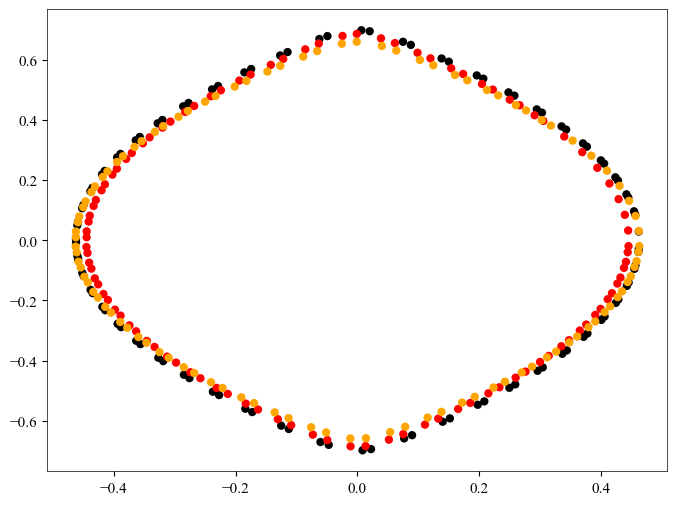

In [180]:
plt.scatter(*ps_new_numerical[0].T.detach())
plt.scatter(*ps_new_ml[0].T.detach(), c='r')
plt.scatter(*ps_og[0].T.detach(), c='orange')

In [ ]:
# ISSUE: 